# Analyzing borrowers’ risk of defaulting
Your project is to prepare a report for a bank’s loan division. You’ll need to find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.

Your report will be considered when building a credit scoring of a potential customer. A credit scoring is used to evaluate the ability of a potential borrower to repay their loan.

# Objective

The objective of this project is to:

Prepare a report for a bank's loan division by analyze a borrower's risk of defaulting.
Apply Data Preprocessing to a real-life analytical case study.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import WordNet Lemmatizer for dealing with categorical variables
!pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer

# import Snowball stemmer
from nltk.stem import SnowballStemmer

In [2]:
#loading our dataset
df = pd.read_csv("Downloads/credit_scoring_eng.csv")

In [3]:
#checking the first few rows of our dataset
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


In [4]:
#checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
#checking the structure of our dataset
df.shape

(21525, 12)

In [6]:
#checking for null value 
df.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

## Missing values

-`days_employed` column has missing of value of 2174 

-`total_income` column also has a missing value of 2174, while other columns have no missing values

In [7]:
#checking the description of our data
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,26787.568355
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,16475.450632
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,32549.611000
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,362496.645000


From the describe() method, for the column `days_employed`, the mean is 63046 and the median is -1203.36. This means that the dataset contains significant outliers. For the column `total_income`, the mean is 26787 and the median is 23202. We could likely replace missing values in this column with the mean or median. Checking through the missing values, we observe that the missing values exhibit a 'systematic' pattern. For each rows with missing data, the days_employed and total_income values are all missing. This means the data is "Missing not at random (MNAR)". That means those who refused to give information about the days employed will likely not give information about their total income. The best option would be to drop those rows with missing value to avoid introducing "variance" or "bias" into our analysis. Moreover, since the sample size is large enough, we can drop the 10% of the missing data without substantial loss of statistical power.

In [8]:
# count of missing data by gender
print('Count of missing days employed by gender')
print(df[df['days_employed'].isnull()]['gender'].value_counts())

print()
print('Count of total income missing by gender')
print(df[df['total_income'].isnull()]['gender'].value_counts())

Count of missing days employed by gender
gender
F    1484
M     690
Name: count, dtype: int64

Count of total income missing by gender
gender
F    1484
M     690
Name: count, dtype: int64


The count of missing data by gender shows that the data is missing not at random. i.e. same number of both gender are missing in the days_employed and total_income columns.

In [9]:
#dropping row with missing values
credit_score_df = df.dropna().reset_index(drop=True)

In [10]:
#cross checking if we still have missing data
credit_score_df.isnull().sum().all()

False

In [11]:
#Checking for unique entry into our dataset
credit_score_df.nunique()

children                8
days_employed       19351
dob_years              58
education              15
education_id            5
family_status           5
family_status_id        5
gender                  3
income_type             8
debt                    2
total_income        19348
purpose                38
dtype: int64

In [12]:
#checking number of unique entry for children column
credit_score_df["children"].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [13]:
#checking number of unique entry for days_employed
credit_score_df["days_employed"].unique()

array([-8437.67302776, -4024.80375385, -5623.42261023, ...,
       -2113.3468877 , -3112.4817052 , -1984.50758853])

In [14]:
#checking number of unique entry for education
credit_score_df["education"].unique()

array(["bachelor's degree", 'secondary education', 'Secondary Education',
       'SECONDARY EDUCATION', "BACHELOR'S DEGREE", 'some college',
       'primary education', "Bachelor's Degree", 'SOME COLLEGE',
       'Some College', 'PRIMARY EDUCATION', 'Primary Education',
       'Graduate Degree', 'GRADUATE DEGREE', 'graduate degree'],
      dtype=object)

In [15]:
#checking number of unique entry for family_status  
credit_score_df["family_status"].unique()

array(['married', 'civil partnership', 'widow / widower', 'divorced',
       'unmarried'], dtype=object)

In [16]:
#checking number of unique entry for gender  
credit_score_df["gender"].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [17]:
#checking number of unique entry for income_type  
credit_score_df["income_type"].unique()

array(['employee', 'retiree', 'business', 'civil servant', 'unemployed',
       'student', 'entrepreneur', 'paternity / maternity leave'],
      dtype=object)

In [18]:
#checking number of unique entry for purpose  
credit_score_df["purpose"].unique()

array(['purchase of the house', 'car purchase', 'supplementary education',
       'to have a wedding', 'housing transactions', 'education',
       'having a wedding', 'purchase of the house for my family',
       'buy real estate', 'buy commercial real estate',
       'buy residential real estate', 'construction of own property',
       'property', 'building a property', 'buying a second-hand car',
       'buying my own car', 'transactions with commercial real estate',
       'housing', 'transactions with my real estate', 'cars',
       'to become educated', 'getting an education',
       'second-hand car purchase', 'car', 'wedding ceremony',
       'to get a supplementary education', 'purchase of my own house',
       'real estate transactions', 'getting higher education',
       'to own a car', 'purchase of a car', 'profile education',
       'university education', 'buying property for renting out',
       'to buy a car', 'building a real estate', 'housing renovation',
       'going

# Conclusion

From the Data Preprocessing section, we computed the number of missing values per column and the percentage of missing values per column. We can see that 10% of rows are missing `days_employed` and `total_income`. Since the type of data with missing values are quantitative, and the data are "Missing not at random", we proceed to drop those rows with missing values. We drop missing rows because 10% of missing values would not really skew our analysis. We also checked for uniqueness in our dataset. We found out that:

`children` has a negative value of -1 so we have to deal with it

`days_employed` have negative value of days. We have to take the absolute value for our analysis to be accurate

`education` has duplicate data

`gender` has an 'XNA' entry. Since there is no logical way to decide whether that entry is for a male or female, we would have to drop that row.

## Data type replacement
After dropping rows, we still observe that the `days_employed` and `total_income` are of float datatype. We need to replace data type and convert from 'float' to 'int'.

In [22]:
#checking data types
credit_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          19351 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         19351 non-null  int64  
 3   education         19351 non-null  object 
 4   education_id      19351 non-null  int64  
 5   family_status     19351 non-null  object 
 6   family_status_id  19351 non-null  int64  
 7   gender            19351 non-null  object 
 8   income_type       19351 non-null  object 
 9   debt              19351 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           19351 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.8+ MB


In [25]:
#changing data types from float to int
credit_score_df['days_employed'] = credit_score_df['days_employed'].astype('int')
credit_score_df['total_income'] = credit_score_df['total_income'].astype('int')

In [26]:
#cross checking our data types
credit_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          19351 non-null  int64 
 1   days_employed     19351 non-null  int32 
 2   dob_years         19351 non-null  int64 
 3   education         19351 non-null  object
 4   education_id      19351 non-null  int64 
 5   family_status     19351 non-null  object
 6   family_status_id  19351 non-null  int64 
 7   gender            19351 non-null  object
 8   income_type       19351 non-null  object
 9   debt              19351 non-null  int64 
 10  total_income      19351 non-null  int32 
 11  purpose           19351 non-null  object
dtypes: int32(2), int64(5), object(5)
memory usage: 1.6+ MB


## Conclusion

`days_employed` and `total_income` column data types have been successfully changed from float to an int data types

In [27]:
credit_score_df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000,19351.000000
mean,0.537388,63046.818717,43.255336,0.819079,0.972249,0.081184,26787.071262
std,1.371408,140826.930322,12.579170,0.550104,1.420596,0.273125,16475.452412
min,-1.000000,-18388.000000,0.000000,0.000000,0.000000,0.000000,3306.000000
25%,0.000000,-2747.000000,33.000000,1.000000,0.000000,0.000000,16488.000000
50%,0.000000,-1203.000000,42.000000,1.000000,0.000000,0.000000,23202.000000
75%,1.000000,-291.000000,53.000000,1.000000,1.000000,0.000000,32549.500000
max,20.000000,401755.000000,75.000000,4.000000,4.000000,1.000000,362496.000000


In [32]:
#converting negative value(-1) in the children column to a positive value(1)
credit_score_df.loc[credit_score_df["children"] == -1, "children"] = 0

#checking value of conversion
credit_score_df["children"].value_counts()

children
0     12754
1      4343
2      1851
3       294
20       67
4        34
5         8
Name: count, dtype: int64

From the value counts, it is quite evident that our negative value has been replaced with 0 with a total value of 12754

In [50]:
#locate index of gender row with 'XNA'
i = credit_score_df[(credit_score_df['gender'] == 'XNA')].index

# drop row in gender with XNA
credit_score_df = credit_score_df.drop(i) 
print('Unique gender are:', credit_score_df['gender'].unique())
print('------------------------------------------')
print('The new shape of our dataframe is', credit_score_df.shape)

Unique gender are: ['F' 'M']
------------------------------------------
The new shape of our dataframe is (19350, 12)


In [40]:
# convert negative 'days_employed' to positive values
credit_score_df['days_employed'] = abs(credit_score_df['days_employed'])
credit_score_df['days_employed'].head(10)

0      8437
1      4024
2      5623
3      4124
4    340266
5       926
6      2879
7       152
8      6929
9      2188
Name: days_employed, dtype: int32

In [48]:
#checking for duplicates in the education column
duplicated = credit_score_df['education'].duplicated().sum()
print('Sum of duplicated values in education is :', duplicated)
print('-----------------------------------------------------')
#checking value counts
value_counts = credit_score_df['education'].value_counts()
print('Value counts of duplicated values in', value_counts)



Sum of duplicated values in education is : 19335
-----------------------------------------------------
Value counts of duplicated values in education
secondary education    12342
bachelor's degree       4222
SECONDARY EDUCATION      705
Secondary Education      646
some college             612
BACHELOR'S DEGREE        251
Bachelor's Degree        243
primary education        231
Some College              40
SOME COLLEGE              22
PRIMARY EDUCATION         16
Primary Education         14
graduate degree            4
Graduate Degree            1
GRADUATE DEGREE            1
Name: count, dtype: int64


In [52]:
#preprocessing duplicates in 'education' column
credit_score_df['education'] = credit_score_df['education'].str.lower()
credit_score_df['education'].value_counts()

education
secondary education    13693
bachelor's degree       4716
some college             674
primary education        261
graduate degree            6
Name: count, dtype: int64

In [53]:
credit_score_df['education'].unique()

array(["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree'], dtype=object)

In [54]:
# processing duplicates in 'purpose' column
credit_score_df['purpose'] = credit_score_df['purpose'].str.lower()
credit_score_df['purpose'] = credit_score_df['purpose'].replace(['wedding ceremony'], 'wedding')
credit_score_df['purpose'].value_counts().sort_values(ascending=False)

purpose
wedding                                     721
to have a wedding                           693
having a wedding                            685
real estate transactions                    615
buy commercial real estate                  597
purchase of the house                       595
buying property for renting out             588
housing                                     587
transactions with commercial real estate    581
building a real estate                      580
housing transactions                        579
purchase of my own house                    574
property                                    572
purchase of the house for my family         570
building a property                         561
construction of own property                560
transactions with my real estate            559
buy real estate                             551
buy residential real estate                 546
housing renovation                          542
car                             

In [58]:
import nltk
from nltk.stem import WordNetLemmatizer

# Download the 'punkt' resource
nltk.download('punkt')

# Download the 'wordnet' resource
nltk.download('wordnet') # This line is added to download wordnet

#preprocessing duplicates in 'education' column
# checking frequency of words in 'purpose' column
allwords = ' '.join(map(str, credit_score_df['purpose']))
allwords = allwords.lower()

wordnet_lemma = WordNetLemmatizer()

# change allwords to a list or words
allwords = nltk.word_tokenize(allwords)

# find and save the lemma of each word
lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in allwords]


from collections import Counter

# print the frequency of each lemma
print(Counter(lemmas))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Counter({'a': 4631, 'real': 4029, 'estate': 4029, 'car': 3897, 'purchase': 3002, 'education': 2800, 'to': 2756, 'of': 2708, 'transaction': 2334, 'property': 2281, 'my': 2155, 'buy': 2136, 'wedding': 2099, 'own': 2014, 'house': 1739, 'housing': 1708, 'buying': 1477, 'commercial': 1178, 'the': 1165, 'for': 1158, 'building': 1141, 'with': 1140, 'second-hand': 872, 'university': 853, 'supplementary': 810, 'getting': 783, 'have': 693, 'having': 685, 'renting': 588, 'out': 588, 'family': 570, 'construction': 560, 'residential': 546, 'renovation': 542, 'going': 440, 'get': 396, 'an': 393, 'higher': 390, 'profile': 389, 'become': 357, 'educated': 357})


# Conclusion
As we have observed, the duplicate data in the education column may have occured when more than one analysts is involved in data collection and entry. One analyst prefers to write item names using ALL CAPS, another uses maybe Lower case. We have been able to process the duplicates in the education column by using str.lower() method in pandas. We also carried out lemmatization on the purpose column.

In [59]:
# recategorize words in 'purpose'
credit_score_df['purpose'] = credit_score_df['purpose'].replace(
    ['supplementary education', 'university education', 'education', 'to get a supplementary education', 'getting an education', 
     'getting higher education', 'profile education', 'to become educated', 'going to university'], 'education'
)

credit_score_df['purpose'] = credit_score_df['purpose'].replace(
    ['wedding', 'to have a wedding', 'having a wedding'], 'wedding'
)

credit_score_df['purpose'] = credit_score_df['purpose'].replace(
    ['real estate transactions', 'buy commercial real estate', 'building a real estate', 'transactions with commercial real estate', 
     'transactions with my real estate', 'buy real estate', 'buy residential real estate'], 'real estate'
)

credit_score_df['purpose'] = credit_score_df['purpose'].replace(
    ['buying property for renting out', 'construction of own property', 'property', 'building a property'], 'property'
)

credit_score_df['purpose'] = credit_score_df['purpose'].replace(
    ['purchase of the house', 'housing', 'housing transactions', 'purchase of my own house', 
     'purchase of the house for my family', 'housing renovation'], 'house purchase'
)

credit_score_df['purpose'] = credit_score_df['purpose'].replace(
    ['car', 'buying my own car', 'to buy a car', 'buying a second-hand car', 'second-hand car purchase', 'to own a car', 
     'cars', 'car purchase', 'purchase of a car'], 'car purchase'
)

In [61]:
credit_score_df['purpose'].head()

0    house purchase
1      car purchase
2    house purchase
3         education
4           wedding
Name: purpose, dtype: object

In [62]:
#create copy of dataframe to use for encoding
credit_score_df_encode = credit_score_df.copy()

In [64]:
credit_score_df['education'].unique()

array(["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree'], dtype=object)

In [68]:
#Encoding education column
education_encode = {'education' : {"primary education" : 1, "secondary education" : 2, "some college" : 3, 
                "bachelor's degree" : 4, "graduate degree" : 5} }
print(education_encode)
credit_score_df_encode.replace(education_encode, inplace=True)

{'education': {'primary education': 1, 'secondary education': 2, 'some college': 3, "bachelor's degree": 4, 'graduate degree': 5}}


0        4
1        2
2        2
3        2
4        2
        ..
19346    2
19347    2
19348    2
19349    2
19350    2
Name: education, Length: 19350, dtype: int64

In [70]:
# encoding 'family_status' column
labels = credit_score_df_encode['family_status'].astype('category').cat.categories.tolist()
family_status_encode = {'family_status' : {k: v for k,v in zip(labels, list(range(1, len(labels)+1)))}}

print(family_status_encode)
credit_score_df_encode.replace(family_status_encode, inplace =True)

{'family_status': {'civil partnership': 1, 'divorced': 2, 'married': 3, 'unmarried': 4, 'widow / widower': 5}}


In [71]:
# encoding 'income_type' column
labels = credit_score_df_encode['income_type'].astype('category').cat.categories.tolist()
income_type_encode = {'income_type' : {k: v for k,v in zip(labels, list(range(1, len(labels)+1)))}}

print(income_type_encode)
credit_score_df_encode.replace(income_type_encode, inplace =True)

{'income_type': {'business': 1, 'civil servant': 2, 'employee': 3, 'entrepreneur': 4, 'paternity / maternity leave': 5, 'retiree': 6, 'student': 7, 'unemployed': 8}}


In [72]:
# encoding 'purpose' column
labels = credit_score_df_encode['purpose'].astype('category').cat.categories.tolist()
purpose_encode = {'purpose' : {k: v for k,v in zip(labels, list(range(1, len(labels)+1)))}}

print(purpose_encode)
credit_score_df_encode.replace(purpose_encode, inplace =True)

{'purpose': {'car purchase': 1, 'education': 2, 'house purchase': 3, 'property': 4, 'real estate': 5, 'wedding': 6}}


In [73]:
# encoding 'gender' column
labels = credit_score_df_encode['gender'].astype('category').cat.categories.tolist()
gender_encode = {'gender' : {k: v for k,v in zip(labels, list(range(1, len(labels)+1)))}}

print(gender_encode)
credit_score_df_encode.replace(gender_encode, inplace =True)

{'gender': {'F': 1, 'M': 2}}


In [74]:
# show all categories with encoding
credit_score_df_encode.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,4,0,3,0,1,3,0,40620,3
1,1,4024,36,2,1,3,0,1,3,0,17932,1
2,0,5623,33,2,1,3,0,2,3,0,23341,3
3,3,4124,32,2,1,3,0,2,3,0,42820,2
4,0,340266,53,2,1,1,1,1,6,0,25378,6
5,0,926,27,4,0,1,1,2,1,0,40922,3
6,0,2879,43,4,0,3,0,1,1,0,38484,3
7,0,152,50,2,1,3,0,2,3,0,21731,2
8,2,6929,35,4,0,1,1,1,3,0,15337,6
9,0,2188,41,2,1,3,0,2,3,0,23108,3


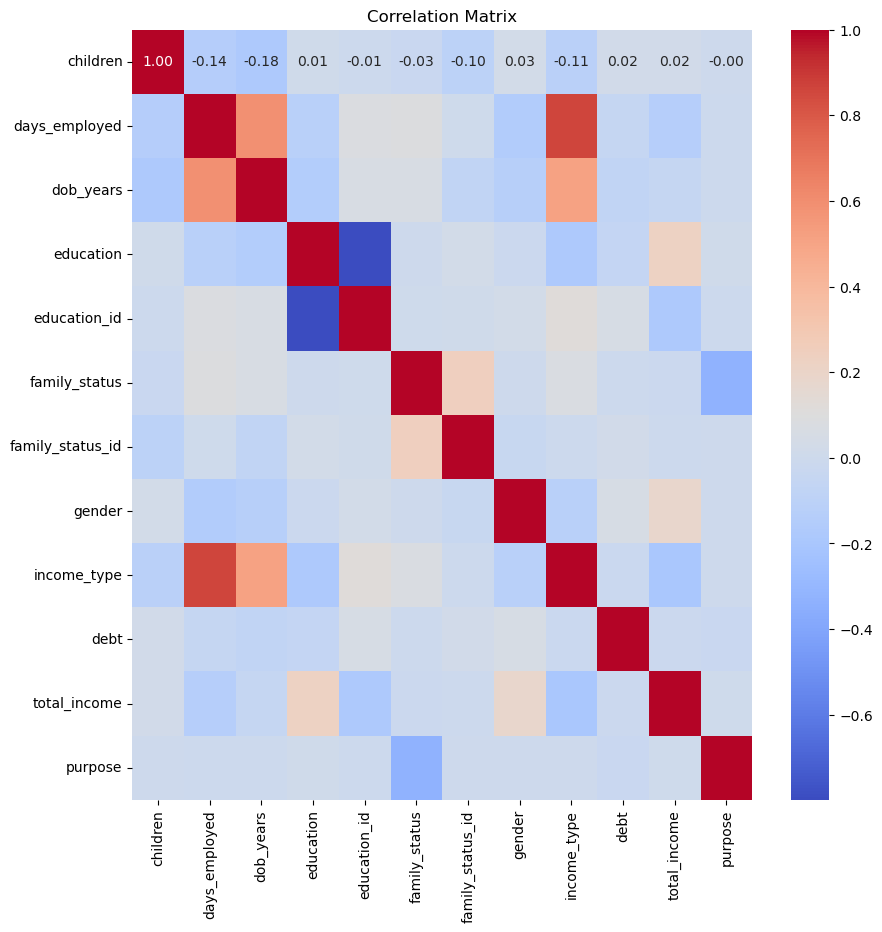

In [83]:
#ploting correlation matrix

plt.figure(figsize=(10, 10))
corr = credit_score_df_encode.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

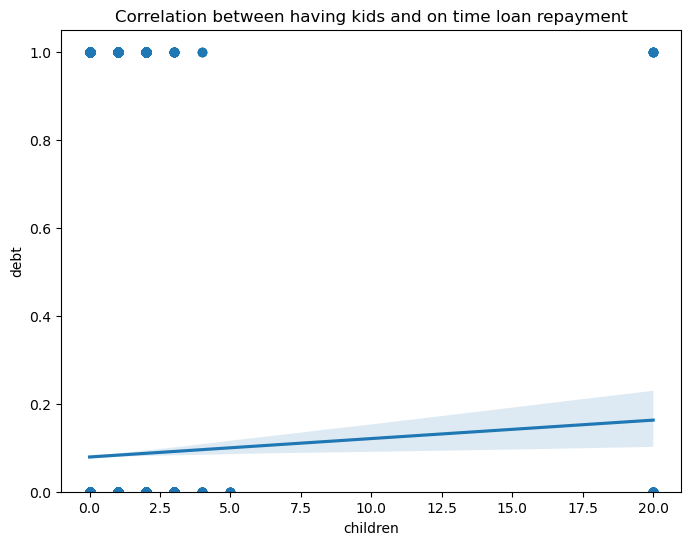

In [88]:
# having kids as a potential predictor of repaying a loan on time
plt.figure(figsize=(8, 6))
sns.regplot(x='children', y='debt', data=credit_score_df_encode)
plt.ylim(0,)
plt.title('Correlation between having kids and on time loan repayment')
plt.show()

First we start to analyze the data by creating a correlation matrix. Our correlation matrix does show that the linear relationship isn't extremely strong (~0.021) across the dataset. Ofcourse, we need to understand that **correlation does not imply causation** thus we need to look for another way to extract insight from the data. One such way is by using a pivot table and plotting the characteristics of the table.

In [89]:
# generate pivot table
loan_table = pd.pivot_table(credit_score_df, index = ['children', 'family_status'],
                            values = 'debt',
                            aggfunc = ['sum', len, 'mean']
                           )
loan_table

sum   len      mean
                           debt  debt      debt
children family_status                         
0        civil partnership  202  2468  0.081848
         divorced            49   717  0.068340
         married            462  6768  0.068262
         unmarried          192  2038  0.094210
         widow / widower     48   762  0.062992
1        civil partnership  102   897  0.113712
         divorced            19   280  0.067857
         married            230  2683  0.085725
         unmarried           51   407  0.125307
         widow / widower      6    76  0.078947
2        civil partnership   26   305  0.085246
         divorced             6    74  0.081081
         married            135  1389  0.097192
         unmarried            8    66  0.121212
         widow / widower      2    17  0.117647
3        civil partnership    6    45  0.133333
         divorced             1    10  0.100000
         married             14   226  0.061947
         unmarried            1     7  0.142857
         widow / widower      0     6  0.000000
4        civil partnership    0     7  0.000000
         divorced             0     1  0.000000
         married              2    24  0.083333
         unmarried            1     1  1.000000
         widow / widower      0     1  0.000000
5        civil partnership    0     1  0.000000
         married              0     7  0.000000
20       civil partnership    3    11  0.272727
         divorced             1     1  1.000000
         married              3    46  0.065217
         unmarried            1     6  0.166667
         widow / widower      0     3  0.000000

Text(0.5, 1.0, 'Plot of debt vs number of children')

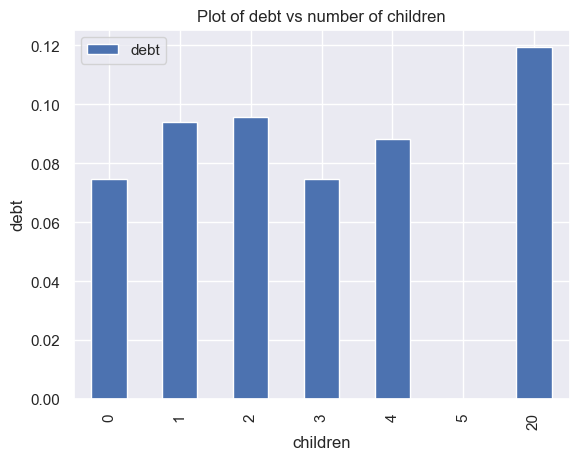

In [90]:
# plot of debt vs number of children
sns.set()
pd.pivot_table(credit_score_df, index = 'children', values = 'debt').plot(kind= 'bar')
plt.ylabel('debt')
plt.title('Plot of debt vs number of children')

Overall, we can see that people with more kids tends to have more debt. Statistically speaking, people with more than 5 kids and up to 20 kids are ~37% more likely to be in debt than people with no kid. This is a reasonable figure when you consider the fact that having more kid means you end up with more responsibility. We can continue to dissect the data to generate more insight by looking at `debt` vs `number of children` with `family status` consideration.en')

Text(0.5, 1.0, 'Plot of debt vs number of children with family status consideration')

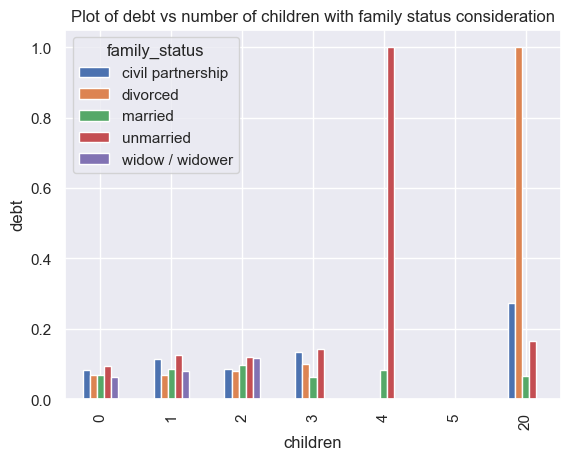

In [91]:
# plot of debt vs number of children with family status consideration
sns.set()
pd.pivot_table(credit_score_df, index = 'children', columns= 'family_status', values = 'debt').plot(kind= 'bar')
plt.ylabel('debt')
plt.title('Plot of debt vs number of children with family status consideration')

From the plot above, we can observe that unmarried people with up to 4 kids and divorced people with up to 20 kids are ~75% more likely to be in debt than any other family status, and about 80% more likely to be in debt than people with 3 or less number of children.

In [92]:
# query table to extract more insight
loan_table.query('children == 0')

sum   len      mean
                           debt  debt      debt
children family_status                         
0        civil partnership  202  2468  0.081848
         divorced            49   717  0.068340
         married            462  6768  0.068262
         unmarried          192  2038  0.094210
         widow / widower     48   762  0.062992

In [93]:
# query table to extract more insight
loan_table.query('children == 20')

sum  len      mean
                           debt debt      debt
children family_status                        
20       civil partnership    3   11  0.272727
         divorced             1    1  1.000000
         married              3   46  0.065217
         unmarried            1    6  0.166667
         widow / widower      0    3  0.000000

# Conclusion

From our result above, the data tells us that people with more than 5 kids in general tend to be in more debt than people with less kids. People with more than 5 kids and up to 20 kids are ~37% more likely to be in debt than people with no kid thus, there is a relationship between having kids and repaying a loan on time.

Is there a relation between marital status and repaying a loan on time?
We start by looking at the correlation matrix. We see a weak correlation between family_status and repaying a loan on time across the data. We can slice the data by using pivot table to generate more insight.

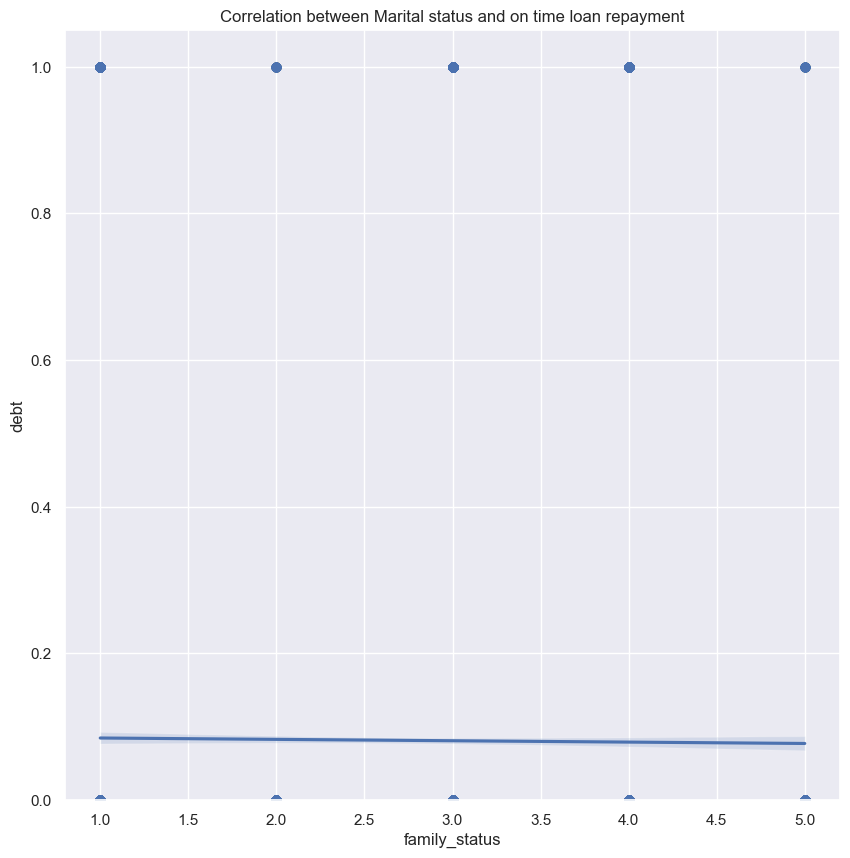

In [98]:
# marital status as a potential predictor of repaying a loan on time
plt.figure(figsize=(10, 10))
sns.regplot(x='family_status', y='debt', data=credit_score_df_encode)
plt.ylim(0,)
plt.title('Correlation between Marital status and on time loan repayment')
plt.show()

In [99]:
# generate pivot table
pd.pivot_table(credit_score_df, index = ['family_status'],
                            values = 'debt',
                            aggfunc = ['sum', len, 'mean']
                           )

,sum,len,mean
,debt,debt,debt
family_status,,,
civil partnership,339,3734,0.090787
divorced,76,1083,0.070175
married,846,11143,0.075922
unmarried,254,2525,0.100594
widow / widower,56,865,0.064740


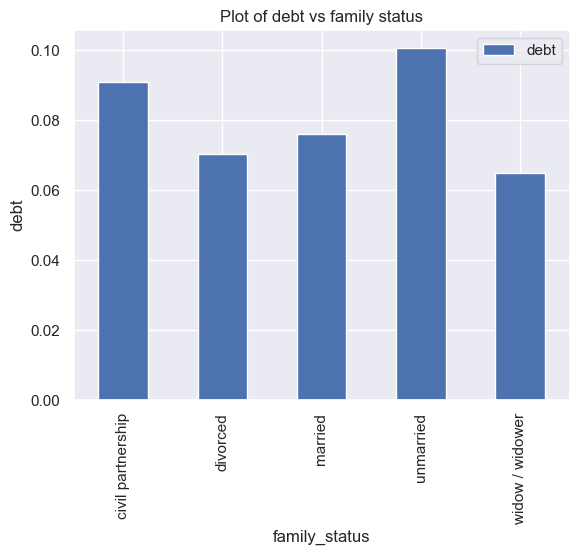

In [101]:
# plot of family status vs debt
sns.set()
pd.pivot_table(credit_score_df, index = 'family_status', values = 'debt').plot(kind= 'bar')
plt.ylabel('debt')
plt.title('Plot of debt vs family status')
plt.show()

From the plot above, unmarried people are more than 2% likely to be in debt than married people. Widow/widower are least likely to be in debt than any of the other groups.

In [102]:
# pivot table with family_status, debt and education
loan_table1 = pd.pivot_table(credit_score_df, 
                             index = ['family_status', 'education'], 
                             values= 'debt', 
                             aggfunc = [len, 'mean']
                            )
loan_table1

len      mean
                                       debt      debt
family_status     education                          
civil partnership bachelor's degree     854  0.055035
                  primary education      50  0.180000
                  secondary education  2679  0.100411
                  some college          151  0.092715
divorced          bachelor's degree     292  0.047945
                  graduate degree         1  0.000000
                  primary education      20  0.100000
                  secondary education   744  0.077957
                  some college           26  0.076923
married           bachelor's degree    2740  0.051825
                  graduate degree         4  0.000000
                  primary education     131  0.106870
                  secondary education  7957  0.083072
                  some college          311  0.093248
unmarried         bachelor's degree     706  0.060907
                  graduate degree         1  0.000000
                  primary education      32  0.093750
                  secondary education  1613  0.117793
                  some college          173  0.104046
widow / widower   bachelor's degree     124  0.048387
                  primary education      28  0.000000
                  secondary education   700  0.068571
                  some college           13  0.153846

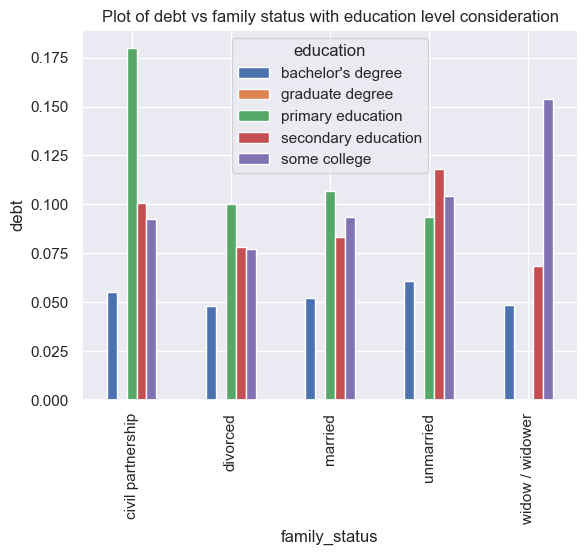

In [105]:
# plot of debt vs family status with education level consideration
sns.set()
pd.pivot_table(credit_score_df, index = 'family_status', columns= 'education', values = 'debt').plot(kind= 'bar')
plt.ylabel('debt')
plt.title('Plot of debt vs family status with education level consideration')
plt.show()

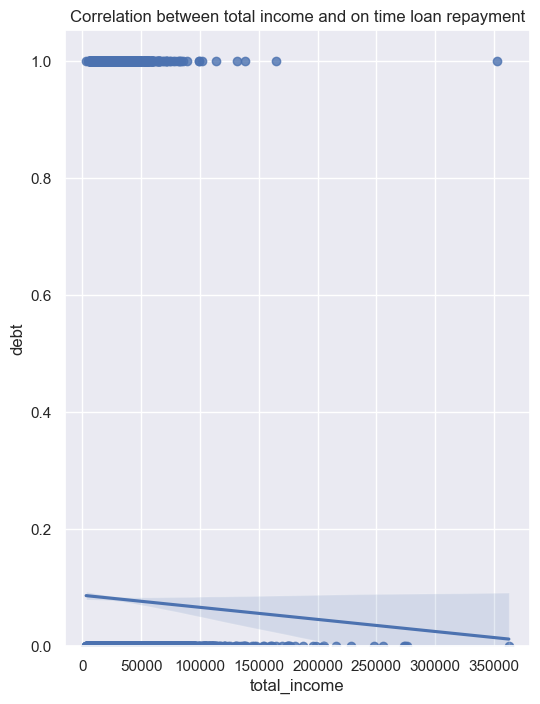

In [108]:
# total income as a potential predictor of repaying a loan on time
plt.figure(figsize=(6,8))
sns.regplot(x='total_income', y='debt', data=credit_score_df_encode)
plt.ylim(0,)
plt.title('Correlation between total income and on time loan repayment')
plt.show()

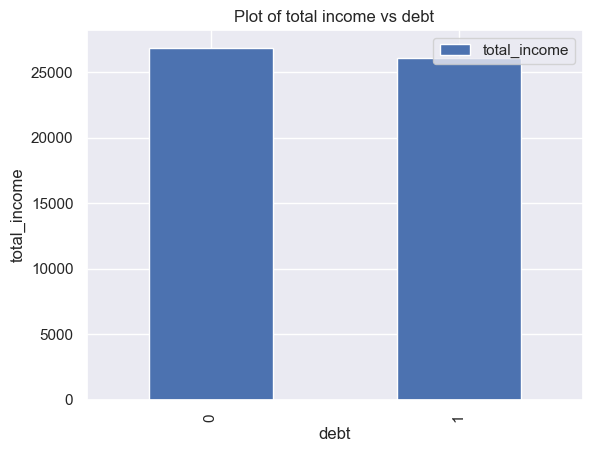

In [111]:
# plot of total income vs debt
sns.set()
pd.pivot_table(credit_score_df, index = 'debt', values = 'total_income').plot(kind= 'bar')
plt.ylabel('total_income')
plt.title('Plot of total income vs debt')
plt.show()

In [112]:
# pivot table with total_income vs debt
loan_table2 = pd.pivot_table(credit_score_df, 
                             index = 'total_income', 
                             values= 'debt', 
                             aggfunc = ['mean', min, max]
                            )
loan_table2

C:\Users\USER\AppData\Local\Temp\ipykernel_2468\3681113606.py:2: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  loan_table2 = pd.pivot_table(credit_score_df,
C:\Users\USER\AppData\Local\Temp\ipykernel_2468\3681113606.py:2: FutureWarning: The provided callable <built-in function max> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  loan_table2 = pd.pivot_table(credit_score_df,


,mean,min,max
,debt,debt,debt
total_income,,,
3306,1.0,1,1
3392,0.0,0,0
3418,0.0,0,0
3471,0.0,0,0
3503,0.0,0,0
...,...,...,...
273809,0.0,0,0
274402,0.0,0,0


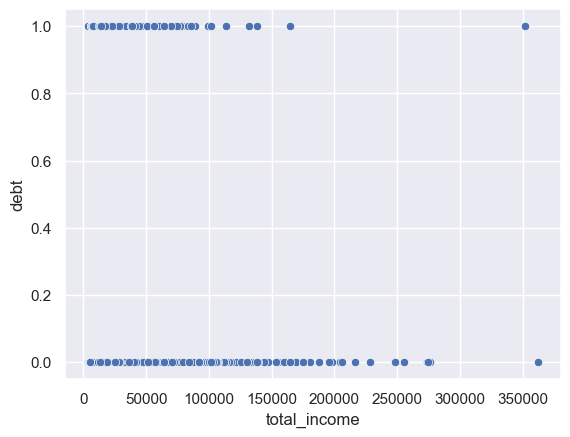

In [114]:
# generate scatter plot 
ax = sns.scatterplot(x='total_income', y='debt', data=credit_score_df )

# Conclusion

From the correlation matrix, we have a weak negative correlation between total_income and debt. Looking further at the pivot table, we cannot derive any relationship between total_income and debt.

How do different loan purposes affect on-time repayment of the loan?

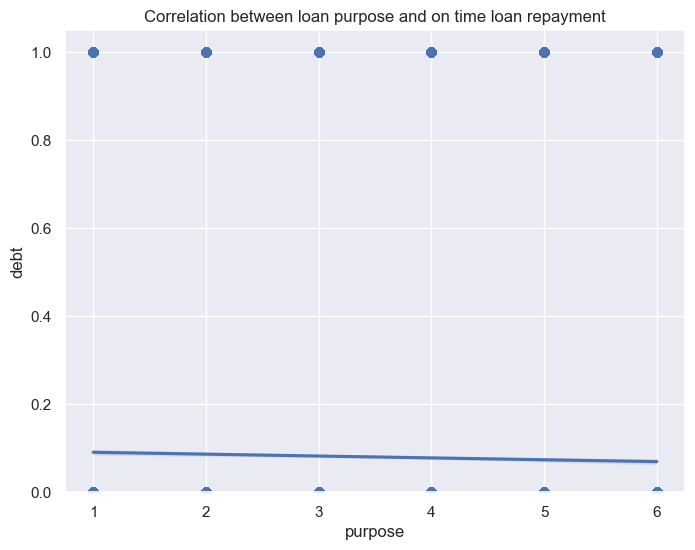

In [118]:
# different loan purposes as a potential predictor of repaying a loan on time
plt.figure(figsize=(8, 6))
sns.regplot(x='purpose', y='debt', data=credit_score_df_encode)
plt.ylim(0,)
plt.title('Correlation between loan purpose and on time loan repayment')
plt.show()


In [121]:
 #pivot table with purpose vs debt
loan_table3 = pd.pivot_table(credit_score_df, 
                             index = ['purpose'], 
                             values= 'debt', 
                             aggfunc = ['sum', len, 'mean']
                            )
loan_table3

,sum,len,mean
,debt,debt,debt
purpose,,,
car purchase,367,3897,0.094175
education,331,3597,0.092021
house purchase,237,3447,0.068755
property,173,2281,0.075844
real estate,305,4029,0.075701
wedding,158,2099,0.075274


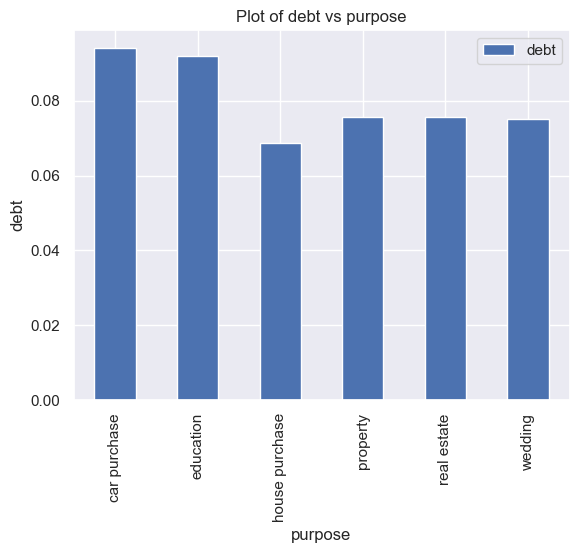

In [123]:
# plot of purpose vs debt
sns.set()
pd.pivot_table(credit_score_df, index = 'purpose', values = 'debt').plot(kind= 'bar')
plt.ylabel('debt')
plt.title('Plot of debt vs purpose')
plt.show()